In [1]:
import os
import tqdm
import math
import numpy as np
import csv
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal
from torch.nn.utils import clip_grad_norm_
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'

# Modify RL dataset

### Functions

In [2]:
def compute_actions(cuevel, cueDirection, cueposfront, cueposback):
    cueAngle = min_max_standardisation(compute_angle(cuevel, cueDirection), min_val=45, max_val=135)

    #cueacceleration =  normalize(compute_acceleration(cuevel[["x","y","z"]].to_numpy()))      # min_max_standardisation() #, min_val=-140, max_val=140)
    actions = np.hstack((cueAngle.reshape(-1,1), normalize(cuevel[["x","y","z"]].to_numpy())))   #, cueacceleration)) #, normalize(cueacceleration))  
    #vel_x = min_max_standardisation(cuevel[["x"]].to_numpy())
    #vel_y = min_max_standardisation(cuevel[["y"]].to_numpy())
    #vel_z = min_max_standardisation(cuevel[["z"]].to_numpy())
    #actions = np.hstack((cueAngle.reshape(-1,1), cueposfront[["x", "y", "z"]].to_numpy(), cueposback[["x", "y", "z"]].to_numpy(), vel_x, vel_y, vel_z))  #, cuevel.to_numpy())
    return actions  #cueAngle, cueMagnitude

def compute_acceleration(cuevel):
    dt = 0.0111
    acc = np.zeros(cuevel.shape)
    for i in range(len(cuevel)):
        if i == 0:
            acc[i][:] = 0   #(np.abs(cuevel[i][:]-0))/dt
        else:
            acc[i][:] = (cuevel[i][:]-cuevel[i-1][:])/dt
            #if np.abs(acc[i][0]) > 10 or np.abs(acc[i][1]) > 10:
                #print("cuevel values for big acc: ", cuevel[i][:], cuevel[i-1][:], i)
    
    return acc
        
def normalize(array):
    #array must be 1-dimensional
    min_val = array.min()
    max_val = np.abs(array).max()
    print("min and max value of acceleration standardization: ", min_val, max_val)
    array = array/max_val
    return array
    
def min_max_standardisation(array, min_val=0, max_val = 0): #=45, max_val=135 ):
    #array must be 1-dimensional
    if min_val == 0:
        min_val = array.min()
        max_val = array.max()
    print("min and max value of actions standardization: ", min_val, max_val)
    #print("min, max: ", min_val, max_val)
    array = (array - min_val) / (max_val - min_val)
    return array

def compute_angle(cuevel, cueDirection):
    #cueAngle1 = np.rad2deg(np.arctan2(cuevel['z'].values, cuevel['x'].values))
    #print("cue Angle vel: ", cueAngle1)
    cueAngle = np.rad2deg(np.arctan2(cueDirection["z"].values, cueDirection["x"].values))  
    #print("cue Angle Direction: ", cueAngle)
    return cueAngle

def compute_angle_for_funnel(cuevel, cueDirection):
    cueAngle = np.rad2deg(np.arctan2(cueDirection.iloc[2], cueDirection.iloc[0]))      
    return cueAngle

def compute_impulseForce(cuevel, cuedirection):
    impulseForce = np.zeros(cuevel.shape)       #(N,2)
    shotMagnitude = np.zeros(1)
    shotDir = np.zeros(cuedirection.shape)
    #Reward: magnitude range
    lbMagnitude = 0.1   #0.516149
    ubMagnitude = 3 #0.882607

    shotMagnitude = np.sqrt(np.square(cuevel).sum(axis=1))
    #np.linalg.norm(cuevel, axis=1)
    for i in range(cuevel.shape[0]):
        if shotMagnitude[i] > ubMagnitude:
            shotMagnitude[i] = ubMagnitude
        elif shotMagnitude[i] < lbMagnitude:
            shotMagnitude[i] = 0

        shotDir[i][0] = cuedirection["x"].iloc[i]
        shotDir[i][1] = cuedirection["z"].iloc[i]
        if shotMagnitude[i] == 0:
            impulseForce[i][:] = 0
        else:
            impulseForce[i][:] = shotMagnitude[i] * shotDir[i][:]
    return shotMagnitude, impulseForce

### Helping Rewards definition to ease learning

In [3]:
def angle_funnel_reward(dataset):
    #reward_ = []
    up_bound_angle = 105.5
    lo_bound_angle = 104.5
    for i in dataset["trial"].unique():
        terminals_ind = dataset["trial"][dataset["terminals"]==True]
        end_funnel = terminals_ind[dataset["trial"] == i].index[0] -30
        start_funnel = end_funnel-30
        for j in range(start_funnel, end_funnel+1):
            angle = compute_angle_for_funnel(dataset["states"][[21,22,23]].iloc[j], dataset["states"][[18,19,20]].iloc[j])
            if angle >= lo_bound_angle and angle <= up_bound_angle:
                if dataset["rewards"].iloc[j] != -10.0 and dataset["rewards"].iloc[j] != 100.0 and dataset["rewards"].iloc[j] != 5.0:
                    dataset["rewards"].iloc[j] = 2
                    #print("changed non terminal: ", j, dataset["rewards"].iloc[j])
                else:
                    dataset["rewards"].iloc[j] = dataset["rewards"].iloc[j]+2
                    #print("changed terminal: ", j, dataset["rewards"].iloc[j])
    return dataset

In [4]:
def cueposfront_reward(dataset):
    radius = 0.0005
    vertical_margin = 0.001
    for i in dataset["trial"].unique():
        terminals_ind = dataset["trial"][dataset["terminals"]==True]
        end_funnel = terminals_ind[dataset["trial"] == i].index[0] -30
        start_funnel = end_funnel-30
        for j in range(start_funnel, end_funnel+1):
            if (dataset["states"][12].iloc[j]-dataset["states"][0].iloc[j])**2 + (dataset["states"][14].iloc[j]-dataset["states"][2].iloc[j])**2 < radius \
            and dataset["states"][13].iloc[j] < dataset["states"][1].iloc[j] + vertical_margin: 
                
                if dataset["rewards"].iloc[j] != -10.0 and dataset["rewards"].iloc[j] != 100.0 and dataset["rewards"].iloc[j] != 5.0:
                    dataset["rewards"].iloc[j] = 5
                    #print("changed non terminal: ", i, dataset["rewards"][dataset["trial"]==i][dataset["terminals"] == True], j, dataset["rewards"].iloc[j])
    return dataset

In [5]:
def cueposfront_acceleration_reward(dataset):
    acc_bound = 0.05
    for i in dataset["trial"].unique():
        terminals_ind = dataset["trial"][dataset["terminals"]==True]
        end_funnel = terminals_ind[dataset["trial"] == i].index[0] -30
        start_funnel = end_funnel-30
        for j in range(start_funnel, end_funnel+1):
            if (dataset["states"][21].iloc[j]-dataset["states"][21].iloc[j-1]) > acc_bound  or (dataset["states"][23].iloc[j]-dataset["states"][23].iloc[j-1]) > acc_bound: 
                
                if dataset["rewards"].iloc[j] != -10.0 and dataset["rewards"].iloc[j] != 100.0 and dataset["rewards"].iloc[j] != 5.0:
                    dataset["rewards"].iloc[j] = 1
                    #print("changed non terminal: ")
    return dataset

In [6]:
def reset_rewards(dataset):
    rew_wo_0_val = dataset["rewards"][dataset["rewards"]!=0]
    rew_wo_0_10_val = rew_wo_0_val[dataset["rewards"]!= -10.0]
    ind = rew_wo_0_10_val[dataset["rewards"]!= 100.0].index
    dataset["rewards"][ind] = 0.0
    return dataset

### RL dataset

In [7]:
def Offline_reduced(data, cue_data, cuevel, rewards, state_dim=14, action_dim=2):   #state_dim should be a multiple of 6
    
    print("Offline RL Dataset function")
    #number of trial
    N = len(data["cueballpos"]["trial"])-1   #len(data[initial]["start_ind"])
    print(N)
    state_ = []
    new_state_ = []
    action_ = []
    reward_ = []
    done_ = []
    trial_ = []

    state = np.zeros(state_dim)  #np.zeros(21)
    new_state = np.zeros(state_dim)  #np.zeros(21)
    #action = np.zeros(13)   #12)
    #action = np.zeros(action_dim)
    #reward = np.zeros(1)
    #ball_states=6
    #cue_states=6
    #cue_states_iterations = int((state_dim-ball_states)/(cue_states))

    #Action Velocity, Force?
    #See car 2D -> action space acceleration and cueDirection
    #actions = compute_actions(cuevel[["x", "z"]], cue_data["cuedirection"][["x", "z"]], cue_data["cueposfront"][["x", "z"]], cue_data["cueposback"][["x", "z"]])
    actions = compute_actions(cuevel, cue_data["cuedirection"], cue_data["cueposfront"], cue_data["cueposback"])
    
    for i in range(N):
        count=0
        #count_action=0
        for x in data:
            state[count] = data[str(x)]["x"].iloc[i]
            state[count+1] = data[str(x)]["y"].iloc[i]
            state[count+2] = data[str(x)]["z"].iloc[i]
            new_state[count] = data[str(x)]["x"].iloc[i+1]
            new_state[count+1] = data[str(x)]["y"].iloc[i+1]
            new_state[count+2] = data[str(x)]["z"].iloc[i+1]
            count+=3

        #Add last j timesteps of the cuepos to states
        #3 observations on x and z axis makes 6 observations
        #for j in range(cue_states_iterations): #Warning if state_dim not multiple of 6, division fail for loop
        for x in cue_data:
            state[count] = cue_data[str(x)]["x"].iloc[i]
            state[count+1] = cue_data[str(x)]["y"].iloc[i]
            state[count+2] = cue_data[str(x)]["z"].iloc[i]
            new_state[count] = cue_data[str(x)]["x"].iloc[i+1]
            new_state[count+1] = cue_data[str(x)]["y"].iloc[i+1]
            new_state[count+2] = cue_data[str(x)]["z"].iloc[i+1]
            '''if x == "cueposfront" or x == "cueposback" or x == "cuevel":
                action[count_action] = cue_data[str(x)]["x"].iloc[i+1]
                action[count_action+1] = cue_data[str(x)]["y"].iloc[i+1]
                action[count_action+2] = cue_data[str(x)]["z"].iloc[i+1]
                count_action+=3'''
            count+=3
            
        #Action Velocity, Force?
        action = actions[i][:]  #[count_action:]    #actions[:,i+1] #action is cuepos at t+1
        reward = rewards.iloc[i]
        
        if i == N-1:        #No last timestep due to new_states, so advance reward for the last trial
            done_bool = 1   #True
            reward = rewards.iloc[i+1]
        elif data['cueballpos']['trial'].iloc[i+1] != data['cueballpos']['trial'].iloc[i]:
            done_bool = 1   #True
        else:
            done_bool = 0   #False

        trial_.append(data["cueballpos"]["trial"].iloc[i])
        state_.append(state.copy())
        new_state_.append(new_state.copy())
        action_.append(action.copy())
        reward_.append(reward)
        done_.append(done_bool)
    
    return {
        'trial': np.array(trial_),
        'states': np.array(state_),
        'actions': np.array(action_),
        'new_states': np.array(new_state_),
        'rewards': np.array(reward_),
        'terminals': np.array(done_),
        }

### Save

In [8]:
def save_RL_reduced_dataset(initial):
        df = pd.read_csv("RL_dataset/reduced_data/"+initial+"_reduced_data.csv", header = 0, \
        #df = pd.read_csv("RL_dataset/"+initial+"_raw.csv", header = 0, \
                names = ['rewards','cueballpos', 'cueballvel','redballpos', 'targetcornerpos', 'cueposfront', 'cueposback', 'cuedirection', 'cuevel'], usecols = [1,2,3,4,5,6,7,8,9], lineterminator = "\n")
        df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 
        rewards= pd.DataFrame.from_records(np.array(df['rewards'].astype(str).str.split(','))).astype(float)
        cueballpos = pd.DataFrame.from_records(np.array(df['cueballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cueballvel = pd.DataFrame.from_records(np.array(df['cueballvel'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        redballpos = pd.DataFrame.from_records(np.array(df['redballpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        targetcornerpos = pd.DataFrame.from_records(np.array(df['targetcornerpos'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cueposfront = pd.DataFrame.from_records(np.array(df['cueposfront'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cueposback = pd.DataFrame.from_records(np.array(df['cueposback'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cuedirection = pd.DataFrame.from_records(np.array(df['cuedirection'].str.split(',')), columns=["trial","x","y","z"]).astype(float)
        cuevel = pd.DataFrame.from_records(np.array(df['cuevel'].str.split(',')), columns=["trial","x","y","z"]).astype(float)

        ball_data = {'cueballpos': cueballpos,
             'cueballvel': cueballvel,
            'redballpos': redballpos,
            'targetcornerpos': targetcornerpos
            }
        cue_data = {'cueposfront': cueposfront,
                'cueposback': cueposback,
                'cuedirection': cuedirection,
                'cuevel': cuevel
                }
        dataset = Offline_reduced(ball_data, cue_data, cuevel, rewards[0],state_dim=24)
        new_d = {'trial': dataset["trial"],
                'states': np.zeros(dataset["states"].shape[0], dtype=object),
                'actions': np.zeros(dataset["actions"].shape[0], dtype=object),
                'new_states': np.zeros(dataset["new_states"].shape[0], dtype=object),
                'rewards': dataset["rewards"],
                'terminals': dataset["terminals"]}
        for i in range(dataset["states"].shape[0]):
                new_d['states'][i] = dataset["states"][i][:].tolist()
                new_d['actions'][i] = dataset["actions"][i][:].tolist()
                new_d['new_states'][i] = dataset["new_states"][i][:].tolist()

        pd_dataset = pd.DataFrame.from_dict(new_d)
        pd_dataset.to_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced.csv")
        #pd_dataset.to_csv("RL_dataset/"+initial+".csv")
        print(initial, "reduced Offline dataset saved")

### Call modif

In [9]:
STOP
initial="HZ"
save_RL_reduced_dataset(initial)

NameError: name 'STOP' is not defined

In [ ]:
# Read Saved dataset
initial = "HZ"
df = pd.read_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced.csv", header = 0, \
        names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 

trial = df['trial'].astype(int)
ind = df['trial'][df['trial']==9].index
print(ind)
df.drop(ind, inplace=True)

ind2 = df['trial'][df['trial']==10].iloc[:19].index
df.drop(ind2, inplace=True)
#df.to_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced.csv")
print(df)

### Modify reward to ease learning

In [ ]:
# Read Saved dataset
initial = "AAB"
df = pd.read_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced.csv", header = 0, \
        names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 
states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
#actions= pd.DataFrame.from_records(np.array(df['actions'].str.split(','))).astype(float)
#new_states = pd.DataFrame.from_records(np.array(df['new_states'].str.split(','))).astype(float)
trial = df['trial'].astype(int)
rewards = df['rewards'].astype(float)
terminals = df['terminals'].astype(int)
dataset = {'trial': trial,
                'states': states,
                'rewards': rewards,
                'terminals': terminals}

In [ ]:
dataset = cueposfront_reward(dataset)
dataset = angle_funnel_reward(dataset)
dataset = cueposfront_acceleration_reward(dataset)
#dataset = reset_rewards(dataset)

In [ ]:
pd_df_rew = pd.DataFrame.from_dict(dataset["rewards"])
df['rewards'] = pd_df_rew
df.to_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced_mod_rew.csv")

### Modify reward to ease learning (all subjects)

In [10]:
path = "C:/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 1/"
path2 = "C:/Users/dario/Documents/DARIO/ETUDES/ICL/code/data/Round 2/"
pathlist = [path, path2]
# Environment State Properties				
for path in pathlist:
    for i, initial in enumerate(sorted(os.listdir(path))):
        pathSubj = path + str(initial)
        for fil in range(len(sorted(os.listdir(pathSubj + '/Game/')))):
            if sorted(os.listdir(pathSubj + '/Game/'))[fil].find("Block2") > -1:
                blockFile = sorted(os.listdir(pathSubj + '/Game/'))[fil]
                
                if blockFile.find('Reward') > -1:
                    df = pd.read_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced.csv", header = 0, \
                    names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
                    df = df.replace([r'\n', r'\[', r'\]'], '', regex=True) 
                    #states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
                    #trial = df['trial'].astype(int)
                    rewards = df['rewards'].astype(float)
                    terminals = df['terminals'].astype(int)
                    dataset = {'rewards': rewards}
                    """'trial': trial,
                    'states': states,

                    ,
                    'terminals': terminals"""
                    dataset = reset_rewards(dataset)
                    #dataset = cueposfront_reward(dataset)
                    #dataset = angle_funnel_reward(dataset)
                    #dataset = cueposfront_acceleration_reward(dataset)
                    pd_df_rew = pd.DataFrame.from_dict(dataset["rewards"])
                    df['rewards'] = pd_df_rew
                    df.to_csv("RL_dataset/Offline_reduced_original_rew/"+initial+"_Offline_reduced_mod_rew.csv")
                    print("modify rewards file ", initial, "saved")

modify rewards file  AAB saved
modify rewards file  AS saved
modify rewards file  BL saved
modify rewards file  CP saved
modify rewards file  CX saved
modify rewards file  GS saved
modify rewards file  HZ saved
modify rewards file  IK saved
modify rewards file  JW saved
modify rewards file  KO saved
modify rewards file  LR saved
modify rewards file  MA saved
modify rewards file  MAI saved
modify rewards file  MG saved
modify rewards file  MO saved
modify rewards file  PM saved
modify rewards file  SC saved
modify rewards file  SF saved
modify rewards file  TS saved
modify rewards file  YH saved
modify rewards file  AE saved
modify rewards file  AK saved
modify rewards file  BR saved
modify rewards file  BY saved
modify rewards file  DR saved
modify rewards file  DS saved
modify rewards file  DZ saved
modify rewards file  ES saved
modify rewards file  ESS saved
modify rewards file  HL saved
modify rewards file  JG saved
modify rewards file  JH saved
modify rewards file  JR saved
modify 

# Load Data

## One Subject

In [ ]:
initial = "AAB"
df = pd.read_csv("RL_dataset/Offline_reduced/"+initial+"_Offline_reduced.csv", header = 0, \
        names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]', r'\r'], '', regex=True) 
states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
actions= pd.DataFrame.from_records(np.array(df['actions'].str.split(','))).astype(float)
new_states = pd.DataFrame.from_records(np.array(df['new_states'].str.split(','))).astype(float)
trial = df['trial'].astype(int)
terminals = df['terminals'].astype(bool) #=='True'    #Dataframe Object type converts to string (if convert using astype(bool), all values are True)
#print(df['rewards'])
rewards = df['rewards'].astype(float)
#print(rewards)

## Multiple Subjects

In [ ]:
filename = ["RL_dataset/Offline_reduced/AAB_Offline_reduced.csv", "RL_dataset/Offline_reduced/AS_Offline_reduced.csv", "RL_dataset/Offline_reduced/BL_Offline_reduced.csv",
			"RL_dataset/Offline_reduced/CP_Offline_reduced.csv", "RL_dataset/Offline_reduced/CX_Offline_reduced.csv", 
			"RL_dataset/Offline_reduced/GS_Offline_reduced.csv", "RL_dataset/Offline_reduced/HZ_Offline_reduced.csv",
			"RL_dataset/Offline_reduced/IK_Offline_reduced.csv", "RL_dataset/Offline_reduced/JW_Offline_reduced.csv",
			"RL_dataset/Offline_reduced/KO_Offline_reduced.csv", "RL_dataset/Offline_reduced/LR_Offline_reduced.csv",
			"RL_dataset/Offline_reduced/MA_Offline_reduced.csv", "RL_dataset/Offline_reduced/MAI_Offline_reduced.csv",
			"RL_dataset/Offline_reduced/MG_Offline_reduced.csv", "RL_dataset/Offline_reduced/MO_Offline_reduced.csv",
			"RL_dataset/Offline_reduced/PM_Offline_reduced.csv", "RL_dataset/Offline_reduced/SC_Offline_reduced.csv",
			"RL_dataset/Offline_reduced/SC_Offline_reduced.csv"]

In [ ]:
np.random.seed(0)
################### Load Saved dataset ##################
# Read Saved dataset

df = pd.read_csv(filename[0], header = 0, \
			names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
df = df.replace([r'\n', r'\[', r'\]', r'\r'], '', regex=True) 

states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
actions = pd.DataFrame.from_records(np.array(df['actions'].str.split(','))).astype(float)
new_states = pd.DataFrame.from_records(np.array(df['new_states'].str.split(','))).astype(float)
trial = df['trial'].astype(int)
terminals = df['terminals'].astype(bool)

dataset = {'trial': trial, 
			'states': states,
			'actions': actions,
			'new_states': new_states,
			'rewards': df['rewards'],
			'terminals': terminals}

for i, file in enumerate(filename):
	if i > 0:
		df = pd.read_csv(file, header = 0, \
				names = ['trial','states','actions','new_states','rewards','terminals'], usecols = [1,2,3,4,5,6], lineterminator = "\n")
		df = df.replace([r'\n', r'\[', r'\]', r'\r'], '', regex=True) 
	
		states = pd.DataFrame.from_records(np.array(df['states'].str.split(','))).astype(float)
		actions = pd.DataFrame.from_records(np.array(df['actions'].str.split(','))).astype(float)
		new_states = pd.DataFrame.from_records(np.array(df['new_states'].str.split(','))).astype(float)
		trial = df['trial'].astype(int)
		terminals = df['terminals'].astype(bool)
		
		dataset['trial'] = pd.concat([dataset['trial'], trial+i*250], axis=0)
		dataset['states'] = pd.concat([dataset['states'], states], axis=0)
		dataset['actions'] = pd.concat([dataset['actions'], actions], axis=0)
		dataset['new_states'] = pd.concat([dataset['new_states'], new_states], axis=0)
		dataset['rewards'] = pd.concat([dataset['rewards'], df['rewards']], axis=0)
		dataset['terminals'] = pd.concat([dataset['terminals'], terminals], axis=0)	

states = dataset["states"]
actions = dataset["actions"]
new_states = dataset["new_states"]
trial = dataset["trial"]
terminals = dataset["terminals"]
rewards = dataset["rewards"]

# Graph Mean and std

In [ ]:
# Read Saved dataset

successful_rewards_ind = []
print(len(rewards))
for i in range(len(rewards)):
        if terminals.iloc[i] == True:
                if rewards.iloc[i] != -10.0:
                        successful_rewards_ind = np.append(successful_rewards_ind, i)
successful_trial_list = trial.iloc[successful_rewards_ind]
print(len(successful_trial_list), "successful trials")


successful_actions = actions.iloc[successful_trial_list.index]


614452
362 successful trials


In [ ]:
s_a_ = np.zeros((len(successful_actions), states[trial==1].shape[0], actions.shape[1])) 
u_a_ = np.zeros((len(trial.unique())-len(successful_actions), states[trial==1].shape[0], actions.shape[1]))
j = 0
k = 0
print("a shape: ", actions.shape[1])

episode_len = states[trial==1].shape[0]
for i, trial_ind in enumerate(trial.unique()):
        pad_len = episode_len - actions[trial==trial_ind].shape[0]
        #print("pad len: ", trial_ind, pad_len, episode_len, actions[trial==trial_ind].shape)
        a = actions[trial==trial_ind]
        if np.isin(trial_ind, successful_trial_list):
                if pad_len > 0:
                        #print("pad successful trajectory ", trial_ind)
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan)

                s_a_[j][:][:] = a
                j+=1
        else:
                if pad_len > 0:
                        #print("pad unsuccessful trajectory ", trial_ind)
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan) 
                u_a_[k][:][:] = a
                k+=1 

a shape:  4


s_a shape:  (362, 140, 4)
s_a cuevel shape:  (362, 140, 2)
u_a shape:  (4106, 140, 4)
s_a cuevel shape:  (4106, 140, 2)


"fig3.savefig('analysis/velocity/action_success_vs_unsuccess/multiple_subjects_action_Successful_pattern_mean_x_140t.png', facecolor='w',bbox_inches='tight')\nfig4.savefig('analysis/velocity/action_success_vs_unsuccess/multiple_subjects_action_Unuccessful_pattern_mean_x_140t.png', facecolor='w',bbox_inches='tight')\n\nfig5.savefig('analysis/velocity/action_success_vs_unsuccess/multiple_subjects_action_Successful_pattern_mean_z_140t.png', facecolor='w',bbox_inches='tight')\nfig6.savefig('analysis/velocity/action_success_vs_unsuccess/multiple_subjects_action_Unsuccessful_pattern_mean_z_140t.png', facecolor='w',bbox_inches='tight')"

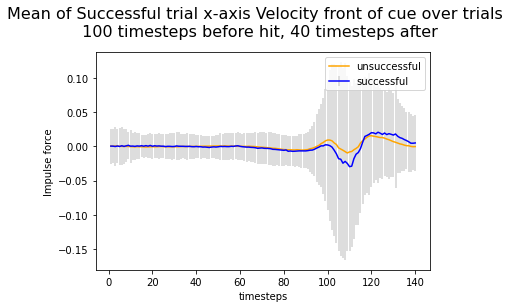

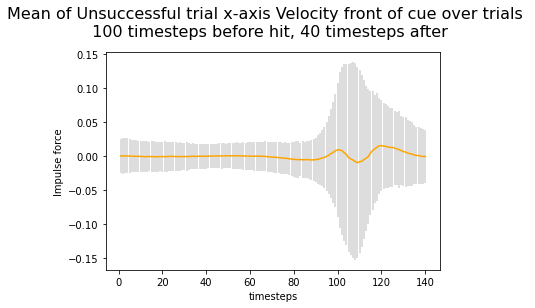

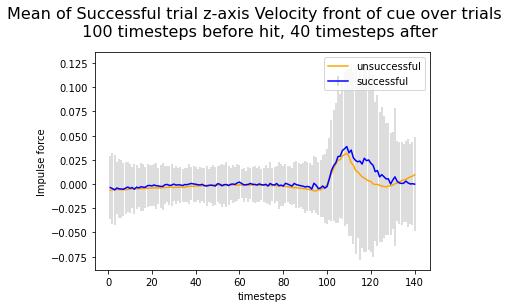

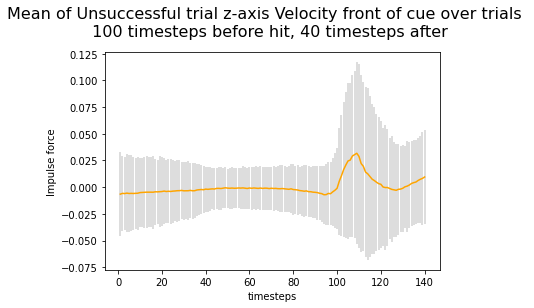

In [ ]:
print("s_a shape: ", s_a_.shape)
s_a = s_a_[:,:,[1, 2]]
print("s_a cuevel shape: ", s_a.shape)
print("u_a shape: ", u_a_.shape)
u_a = u_a_[:,:,[1, 2]]
print("s_a cuevel shape: ", u_a.shape)
successful_mean = np.nanmean(s_a, axis=0, keepdims=True)      
successful_std = np.nanstd(s_a, axis=0)
unsuccessful_mean = np.nanmean(u_a, axis=0)     
unsuccessful_std = np.nanstd(u_a, axis=0)         

successful_mean = successful_mean.reshape(-1)
successful_mean = successful_mean.reshape(episode_len,2)
unsuccessful_mean = unsuccessful_mean.reshape(-1)
unsuccessful_mean = unsuccessful_mean.reshape(episode_len,2)     


fig3, mean_x = plt.subplots()
mean_x.set_xlabel("timesteps")
mean_x.set_ylabel("Impulse force")
fig3.suptitle('Mean of Successful trial x-axis Velocity front of cue over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_x.errorbar(np.arange(1, len(actions[trial == 1])+1), successful_mean[:,0], successful_std[:,0], color='blue', ecolor='lightgrey', label='successful')#, linestyle='None', marker='^')
mean_x.plot(np.arange(1, len(actions[trial == 1])+1), unsuccessful_mean[:,0],  color='orange', label='unsuccessful') 
mean_x.legend()

fig4, mean_x = plt.subplots()
mean_x.set_xlabel("timesteps")
mean_x.set_ylabel("Impulse force")
fig4.suptitle('Mean of Unsuccessful trial x-axis Velocity front of cue over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_x.errorbar(np.arange(1, len(actions[trial == 1])+1), unsuccessful_mean[:,0], unsuccessful_std[:,0], color='orange', ecolor='lightgrey')  # linestyle='None', marker='^')

fig5, mean_z = plt.subplots()
mean_z.set_xlabel("timesteps")
mean_z.set_ylabel("Impulse force")
fig5.suptitle('Mean of Successful trial z-axis Velocity front of cue over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_z.errorbar(np.arange(1, len(actions[trial == 1])+1), successful_mean[:,1], successful_std[:,1], color='blue', ecolor='lightgrey', label='successful')     #, linestyle='None', marker='^')
mean_z.plot(np.arange(1, len(actions[trial == 1])+1), unsuccessful_mean[:,1], color='orange', label='unsuccessful')
mean_z.legend()

fig6, mean_z = plt.subplots()
mean_z.set_xlabel("timesteps")
mean_z.set_ylabel("Impulse force")
fig6.suptitle('Mean of Unsuccessful trial z-axis Velocity front of cue over trials \n 100 timesteps before hit, 40 timesteps after', fontsize=16, y=1.04)
mean_z.errorbar(np.arange(1, len(actions[trial == 1])+1), unsuccessful_mean[:,1], unsuccessful_std[:,1], color='orange', ecolor='lightgrey')



"""fig3.savefig('analysis/velocity/action_success_vs_unsuccess/multiple_subjects_action_Successful_pattern_mean_x_140t.png', facecolor='w',bbox_inches='tight')
fig4.savefig('analysis/velocity/action_success_vs_unsuccess/multiple_subjects_action_Unuccessful_pattern_mean_x_140t.png', facecolor='w',bbox_inches='tight')

fig5.savefig('analysis/velocity/action_success_vs_unsuccess/multiple_subjects_action_Successful_pattern_mean_z_140t.png', facecolor='w',bbox_inches='tight')
fig6.savefig('analysis/velocity/action_success_vs_unsuccess/multiple_subjects_action_Unsuccessful_pattern_mean_z_140t.png', facecolor='w',bbox_inches='tight')"""



# Covariance Matrices

### Position

In [ ]:
successful_trial_list.iloc[0]

26

In [ ]:
#index = 1000

## on a successful trial
index = successful_trial_list.iloc[42]

cueposfront_x = states[trial==index][12]
cueposfront_z = states[trial==index][14]
print(cueposfront_x.shape)

(140,)


### One timestep, for all trials

In [ ]:
ind = terminals[terminals==True].index-40   #find hit index
print(ind)
angle = actions[0].iloc[ind]
vel_x = actions[1].iloc[ind]
print(angle.shape)

Int64Index([   99,   239,   379,   519,   659,   799,   939,  1079,  1219,
             1359,
            ...
            33699, 33839, 33979, 34119, 34259, 34399, 34539, 34679, 34819,
            34958],
           dtype='int64', length=4468)


### One trial, for all timesteps

In [ ]:
index = 1000
angle = actions[trial==index][0]
vel_x = actions[trial==index][1]
vel_z = actions[trial==index][3]
print(angle.shape)

(4468,)


### Mean over all trials, for all timesteps

In [ ]:
s_a = s_a_[:,:,[1, 2]]
u_a = u_a_[:,:,[1, 2]]
successful_mean = np.nanmean(s_a_, axis=0)      
successful_std = np.nanstd(s_a_, axis=0)
unsuccessful_mean = np.nanmean(u_a_, axis=0)     
unsuccessful_std = np.nanstd(u_a_, axis=0)
print(successful_mean.shape, unsuccessful_mean.shape) 

(140, 4) (140, 4)


In [ ]:
angle_s = successful_mean[:,0]
angle_u = unsuccessful_mean[:,0]
vel_x_s = successful_mean[:,1]
vel_x_u = unsuccessful_mean[:,1]
vel_z_s = successful_mean[:,3]
vel_z_u = unsuccessful_mean[:,3]
print(angle_s.shape, angle_u.shape)

(140,) (140,)


In [ ]:
angle = unsuccessful_mean[:,0]
vel_x = unsuccessful_mean[:,1]
vel_z = unsuccessful_mean[:,3]

### Covariance

In [ ]:
m = np.stack((cueposfront_x[85:111], cueposfront_z[85:111]))
print(m.shape)
cov = np.cov(m, rowvar=False)
print(cov.shape)

(2, 26)
(26, 26)


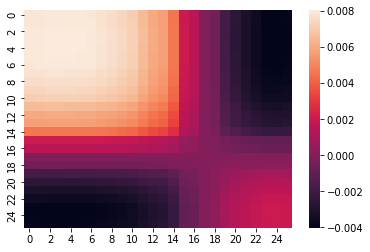

In [ ]:
#timesteps = np.arange(1,141)

sns.heatmap(cov, annot=False, fmt='g')   #, xticklabels=timesteps, yticklabels=timesteps)
plt.show()

# Scatter Point through time

a shape:  4
pad unsuccessful trajectory  250
s_a shape:  (14, 140, 4)
s_a cuevel shape:  (14, 140, 2)
u_a shape:  (235, 140, 4)
s_a cuevel shape:  (235, 140, 2)


MovieWriter imagemagick unavailable; using Pillow instead.
MovieWriter imagemagick unavailable; using Pillow instead.


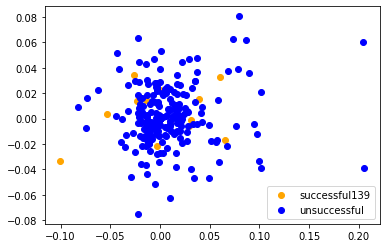

In [ ]:
# Read Saved dataset

successful_rewards_ind = []
for i in range(len(rewards)):
        if terminals.iloc[i] == True:
                if rewards.iloc[i] != -10.0:
                        successful_rewards_ind = np.append(successful_rewards_ind, i)
successful_trial_list = trial.iloc[successful_rewards_ind]
successful_actions = actions.iloc[successful_trial_list.index]

s_a = np.zeros((len(successful_actions), states[trial==1].shape[0], actions.shape[1]))  
u_a = np.zeros((len(trial.unique())-len(successful_actions), states[trial==1].shape[0], actions.shape[1]))
j = 0
k = 0
print("a shape: ", actions.shape[1])

episode_len = states[trial==1].shape[0]
for i, trial_ind in enumerate(trial.unique()):
        pad_len = episode_len - actions[trial==trial_ind].shape[0]
        a = actions[trial==trial_ind]
        if np.isin(trial_ind, successful_trial_list):
                if pad_len > 0:
                        print("pad successful trajectory ", trial_ind)
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan)

                s_a[j][:][:] = a
                j+=1
        else:
                if pad_len > 0:
                        print("pad unsuccessful trajectory ", trial_ind)
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan) 
                u_a[k][:][:] = a
                k+=1 
print("s_a shape: ", s_a.shape)
s_a = s_a[:,:,[1,2]]
print("s_a cuevel shape: ", s_a.shape)
print("u_a shape: ", u_a.shape)
u_a = u_a[:,:,[1,2]]
print("s_a cuevel shape: ", u_a.shape)
successful_mean = np.nanmean(s_a, axis=0, keepdims=True)      #numpy.nanmean()
successful_std = np.nanstd(s_a, axis=0)
unsuccessful_mean = np.nanmean(u_a, axis=0)     #unsuccessful_trial_list
unsuccessful_std = np.nanstd(u_a, axis=0)         #unsuccessful_trial_list

#print(successful_mean.shape[0], successful_mean[:][1])
successful_mean = successful_mean.reshape(-1)
successful_mean = successful_mean.reshape(episode_len,2) #(50,2)
#successful_mean = successful_mean[:,2:4]
unsuccessful_mean = unsuccessful_mean.reshape(-1)
unsuccessful_mean = unsuccessful_mean.reshape(episode_len,2)      #(50,2)


for i in range(25):
        fig, ax_x = plt.subplots()
        index = 85+i
        ax_x.set_xlabel("Velocity z")
        ax_x.set_ylabel("Velocity x")
        fig.suptitle('Velocity points at timestep'+str(index), fontsize=16, y=1.04)
        ax_x.scatter(s_a[:,index,0], s_a[:,index,1], color='orange', label='successful')#, linestyle='None', marker='^')
        ax_x.scatter(u_a[:,index,0], u_a[:,index,1],  color='blue', label='unsuccessful') 
        ax_x.legend()

        fig.savefig('analysis/velocity/scatter_distribution/vel_'+str(index)+'.png', facecolor='w',bbox_inches='tight')
        plt.close()

fig, ax_x = plt.subplots()
fig2, ax_z = plt.subplots()
def animate(i):
	ax_x.clear()
	ax_x.scatter(s_a[:,i,0], s_a[:,i,1], color='orange', label='successful'+str(i))#, linestyle='None', marker='^')
	ax_x.scatter(u_a[:,i,0], u_a[:,i,1],  color='blue', label='unsuccessful') 
	ax_x.legend()

def animate2(i):
	ax_z.clear()

	ax_z.scatter(np.arange(1, s_a.shape[0]+1), s_a[:,i,1], color='orange', label='successful'+str(i))     #, linestyle='None', marker='^')
	ax_z.scatter(np.arange(1, u_a.shape[0]+1), u_a[:,i,1], color='blue', label='unsuccessful')
	ax_z.legend()

anim = animation.FuncAnimation(fig, animate,  frames = s_a.shape[1], interval=160, repeat=False)
anim2 = animation.FuncAnimation(fig2, animate2,  frames = s_a.shape[1], interval=80, repeat=False)	
plt.close()
anim.save('analysis/velocity/scatter_distribution/vel.gif', writer='imagemagick')	
anim2.save('analysis/velocity/scatter_distribution/vel_z.gif', writer='imagemagick')	




# Histograms

a shape:  4
pad unsuccessful trajectory  250
s_a shape:  (14, 140, 4)
s_a cuevel shape:  (14, 140, 2)
u_a shape:  (235, 140, 4)
s_a cuevel shape:  (235, 140, 2)


<ipython-input-8-cff5acf07c87>:56: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax_x = plt.subplots()


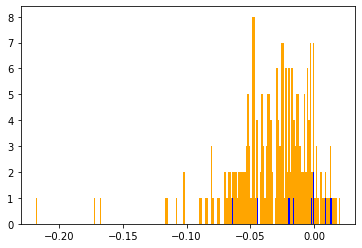

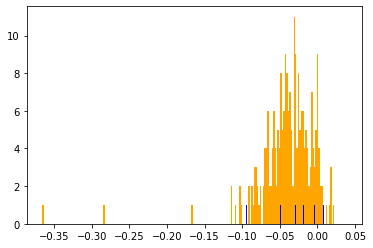

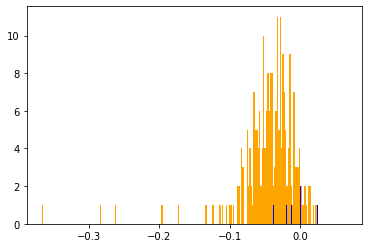

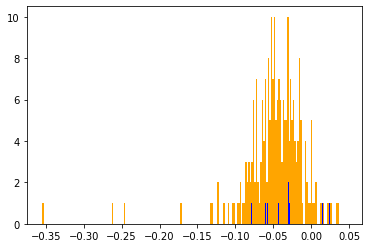

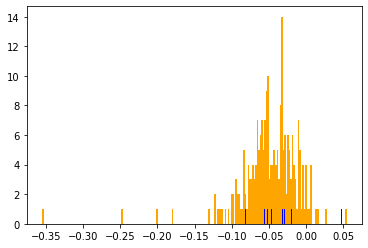

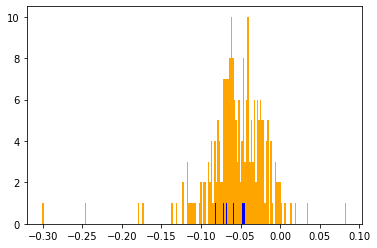

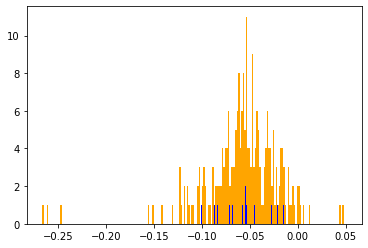

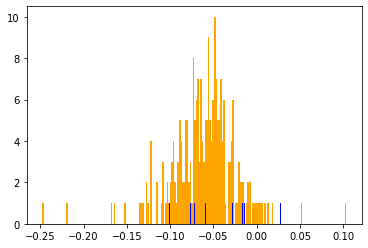

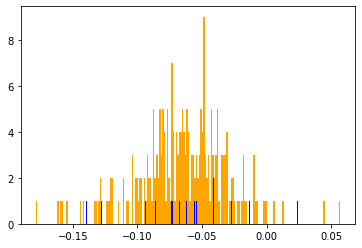

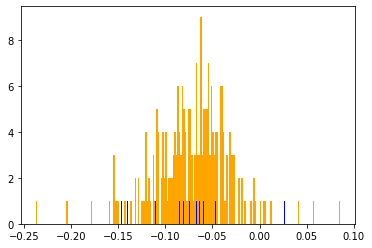

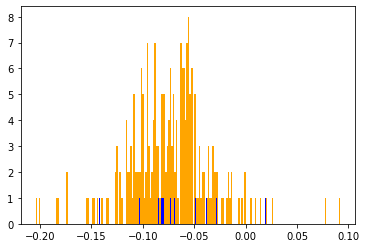

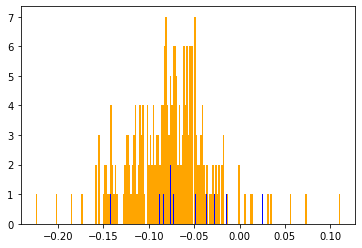

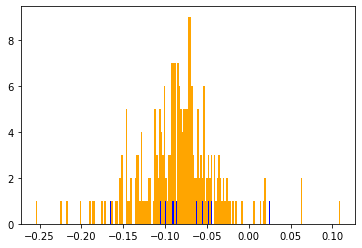

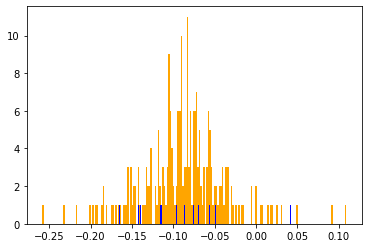

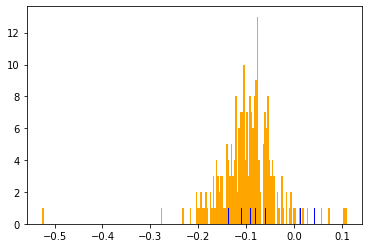

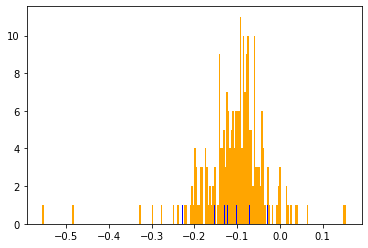

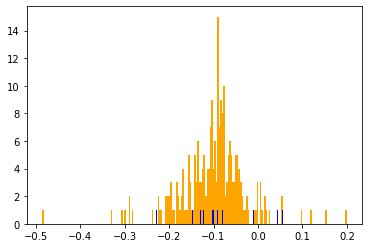

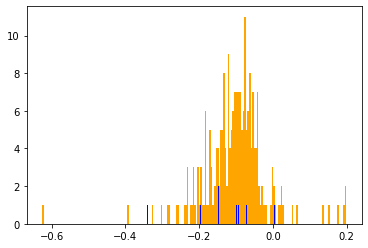

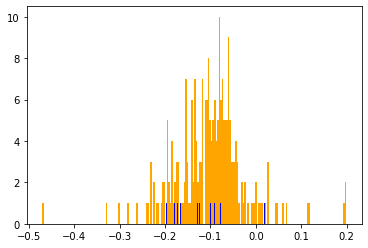

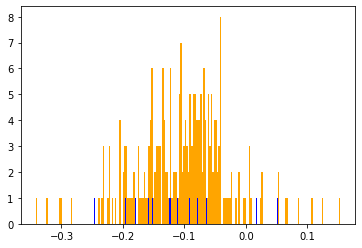

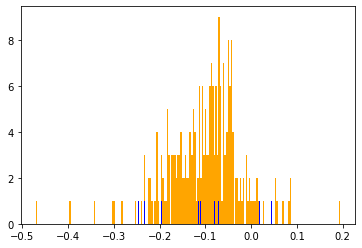

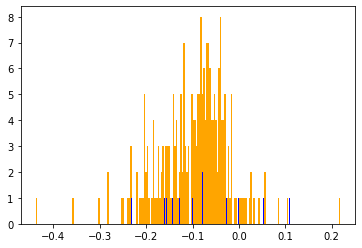

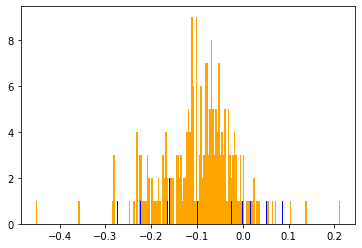

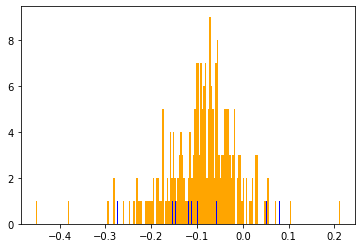

In [ ]:
# Read Saved dataset

successful_rewards_ind = []
for i in range(len(rewards)):
        if terminals.iloc[i] == True:
                if rewards.iloc[i] != -10.0:
                        successful_rewards_ind = np.append(successful_rewards_ind, i)
successful_trial_list = trial.iloc[successful_rewards_ind]
successful_actions = actions.iloc[successful_trial_list.index]

s_a = np.zeros((len(successful_actions), states[trial==1].shape[0], actions.shape[1]))  
u_a = np.zeros((len(trial.unique())-len(successful_actions), states[trial==1].shape[0], actions.shape[1]))
j = 0
k = 0
print("a shape: ", actions.shape[1])

episode_len = states[trial==1].shape[0]
for i, trial_ind in enumerate(trial.unique()):
        pad_len = episode_len - actions[trial==trial_ind].shape[0]
        a = actions[trial==trial_ind]
        if np.isin(trial_ind, successful_trial_list):
                if pad_len > 0:
                        print("pad successful trajectory ", trial_ind)
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan)

                s_a[j][:][:] = a
                j+=1
        else:
                if pad_len > 0:
                        print("pad unsuccessful trajectory ", trial_ind)
                        pad_array = np.array([pad_len*[np.nan]])
                        a = np.pad(a, pad_width = ((pad_len,0), (0,0)),  mode = 'constant', constant_values = np.nan) 
                u_a[k][:][:] = a
                k+=1 
print("s_a shape: ", s_a.shape)
s_a = s_a[:,:,[1,2]]
print("s_a cuevel shape: ", s_a.shape)
print("u_a shape: ", u_a.shape)
u_a = u_a[:,:,[1,2]]
print("s_a cuevel shape: ", u_a.shape)
successful_mean = np.nanmean(s_a, axis=0, keepdims=True)      #numpy.nanmean()
successful_std = np.nanstd(s_a, axis=0)
unsuccessful_mean = np.nanmean(u_a, axis=0)     #unsuccessful_trial_list
unsuccessful_std = np.nanstd(u_a, axis=0)         #unsuccessful_trial_list

#print(successful_mean.shape[0], successful_mean[:][1])
successful_mean = successful_mean.reshape(-1)
successful_mean = successful_mean.reshape(episode_len,2) #(50,2)
#successful_mean = successful_mean[:,2:4]
unsuccessful_mean = unsuccessful_mean.reshape(-1)
unsuccessful_mean = unsuccessful_mean.reshape(episode_len,2)      #(50,2)


for i in range(25):
        fig, ax_x = plt.subplots()
        index = 85+i
        ax_x.hist(u_a[:,index,0], bins=200, histtype = 'bar', color = 'orange', label='unsuccessful')
        ax_x.hist(s_a[:,index,0], bins=200, histtype = 'bar', color = 'blue', label='successful')
        fig.savefig('analysis/velocity/histograms/velocity x-axis/hist_vel_x_'+str(index)+'.png', facecolor='w',bbox_inches='tight')

#fig2, ax_z = plt.subplots()
def animate(i):
	ax_x.clear()
	ax_x.scatter(s_a[:,i,0], s_a[:,i,1], color='blue', label='successful'+str(i))#, linestyle='None', marker='^')
	ax_x.scatter(u_a[:,i,0], u_a[:,i,1],  color='orange', label='unsuccessful') 
	ax_x.legend()

def animate2(i):
	ax_z.clear()

	ax_z.scatter(np.arange(1, s_a.shape[0]+1), s_a[:,i,1], color='orange', label='successful'+str(i))     #, linestyle='None', marker='^')
	ax_z.scatter(np.arange(1, u_a.shape[0]+1), u_a[:,i,1], color='blue', label='unsuccessful')
	ax_z.legend()

#anim = animation.FuncAnimation(fig, animate,  frames = s_a.shape[1], interval=160, repeat=False)
#anim2 = animation.FuncAnimation(fig, animate2,  frames = s_a.shape[1], interval=80, repeat=False)	
plt.close()
#anim.save('analysis/velocity/scatter_distribution/vel.gif', writer='imagemagick')	
#anim2.save('analysis/velocity/scatter_distribution/vel_z.gif', writer='imagemagick')	



# Power Spectrum

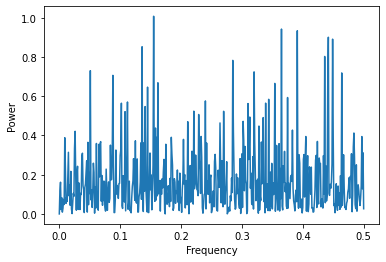

In [ ]:
import numpy as np
from scipy.signal import periodogram

# Generate some random time series data
data = np.random.rand(1000)

# Compute the power spectrum using the periodogram function
freq, power = periodogram(data)

# Plot the power spectrum
import matplotlib.pyplot as plt
plt.plot(freq, power)
plt.xlabel('Frequency')
plt.ylabel('Power')
plt.show()

# K-means clustering